# IHSG Stock Prediction Model Machine Learning

## Import Package

In [1]:
# --- Standard Library ---
import os
import pickle
import logging
from datetime import datetime

# --- Data Manipulation & Acquisition ---
import numpy as np
import pandas as pd
import yfinance as yf

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning: Preprocessing & Selection ---
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# --- Machine Learning: Metrics ---
from sklearn.metrics import (
    accuracy_score, 
    mean_squared_error, 
    confusion_matrix
)

# --- Deep Learning (Keras/TensorFlow) ---
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Specific Models ---
import xgboost as xgb
from prophet import Prophet

2025-11-19 00:36:06.295968: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-19 00:36:06.363448: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-19 00:36:08.151167: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Importing plotly failed. Interactive plots will not work.


In [11]:
%pip install --upgrade yfinance curl-cffi requests

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install yfinance pandas numpy scikit-learn tensorflow matplotlib

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install prophet

Note: you may need to restart the kernel to use updated packages.


## Data Collection

In [47]:

ticker = "^JKSE"
start_date = "2018-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
time_step = 60

# Load dataset
data = yf.download(ticker, start=start_date, end=end_date, interval='1d', progress=False)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = [col[0] for col in data.columns]

# Ubah urutan kolom agar sesuai: Date, Close, High, Low, Open, Volume
data = data[['Close', 'High', 'Low', 'Open', 'Volume']]

# Pastikan index jadi kolom 'Date'
data = data.reset_index()


data_close = data[['Close']].copy()

# ----------------------------------------------------

/tmp/ipykernel_201554/1006436607.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date, interval='1d', progress=False)


In [28]:
data

,Date,Close,High,Low,Open,Volume
0,2018-01-02,6339.237793,6445.910156,6326.092773,6366.083008,52168200
1,2018-01-03,6251.479004,6342.190918,6220.694824,6341.270996,48866400
2,2018-01-04,6292.320801,6292.320801,6233.937012,6257.716797,57864900
3,2018-01-05,6353.737793,6353.737793,6278.724121,6279.457031,74223700
4,2018-01-08,6385.403809,6385.403809,6349.041992,6354.361816,66702400
...,...,...,...,...,...,...
1899,2025-11-12,8388.566406,8428.948242,8377.497070,8392.280273,491096300
1900,2025-11-13,8371.999023,8418.163086,8354.835938,8412.826172,534184900
1901,2025-11-14,8370.435547,8417.134766,8360.936523,8378.128906,422843300
1902,2025-11-17,8416.881836,8452.329102,8391.995117,8397.835938,382110500


## Exploratory Data Analysis (EDA)

In [29]:
data.shape

(1904, 6)

In [30]:
# Check for any missing values
print(data.isnull().sum())

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [31]:
data = data.dropna()

In [32]:
# Check for any missing values
print(data.isnull().sum())

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [33]:
# Summary of data types
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1904 non-null   datetime64[ns]
 1   Close   1904 non-null   float64       
 2   High    1904 non-null   float64       
 3   Low     1904 non-null   float64       
 4   Open    1904 non-null   float64       
 5   Volume  1904 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 89.4 KB
None


In [34]:
# Get summary statistics for numerical columns
data.describe()

,Date,Close,High,Low,Open,Volume
count,1904,1904.000000,1904.000000,1904.000000,1904.000000,1.904000e+03
mean,2021-12-04 09:05:17.647058944,6519.561479,6557.451986,6482.102921,6523.178074,1.514767e+08
min,2018-01-02 00:00:00,3937.632080,4123.562012,3911.716064,3937.632080,0.000000e+00
25%,2019-12-15 06:00:00,6091.170776,6123.215942,6054.193604,6097.067749,9.471258e+07
50%,2021-11-30 12:00:00,6591.464111,6625.443359,6552.550049,6588.073975,1.448037e+08
75%,2023-11-14 06:00:00,7026.387695,7068.123047,6986.117432,7030.193481,1.918540e+08
max,2025-11-18 00:00:00,8416.881836,8478.148438,8391.995117,8443.320312,6.778856e+08
std,NaN,738.241931,738.262564,739.819344,739.710086,7.922141e+07


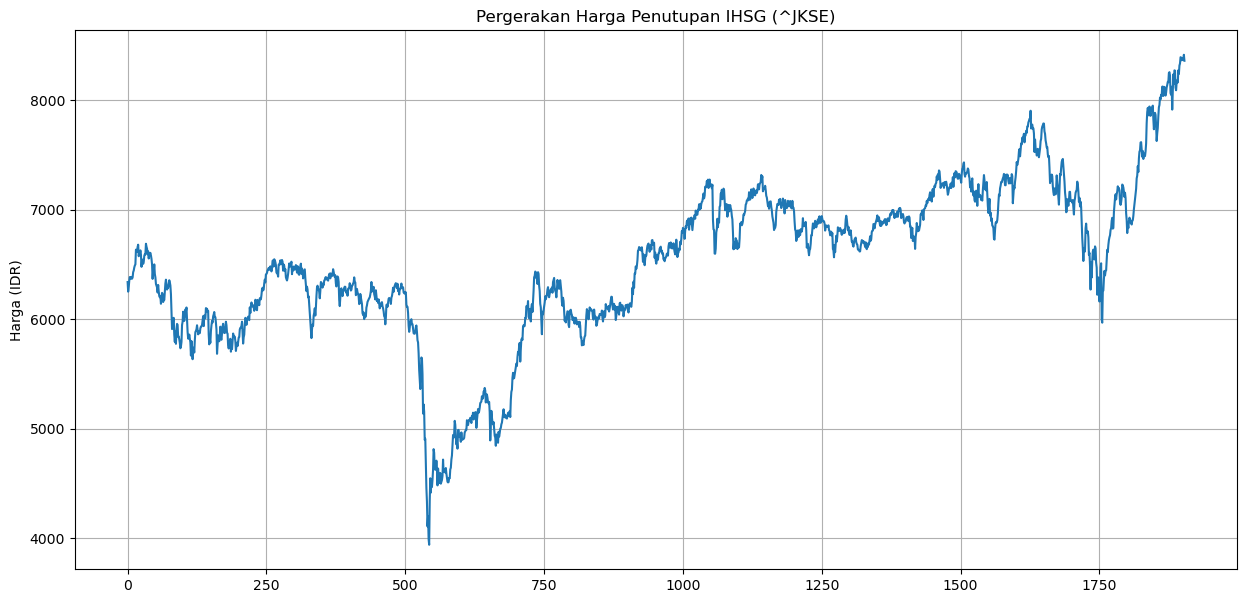

In [35]:
data['Close'].plot(figsize=(15, 7), title='Pergerakan Harga Penutupan IHSG (^JKSE)')
plt.ylabel('Harga (IDR)')
plt.grid(True)
plt.show()

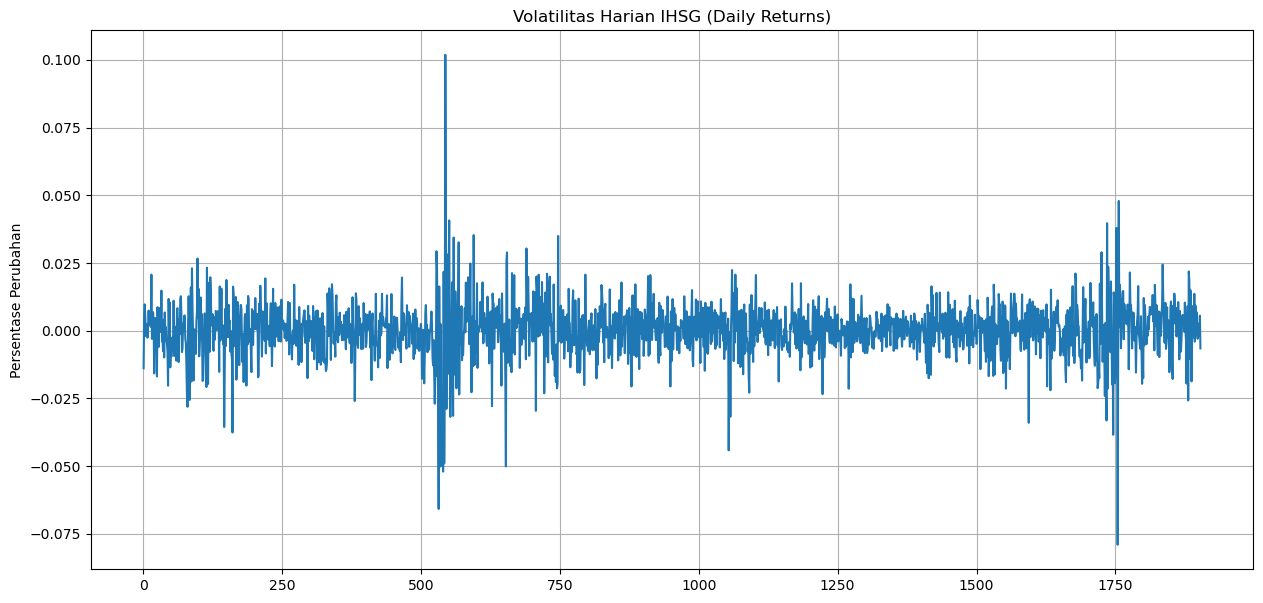

Text(0.5, 1.0, 'Distribusi Daily Returns')

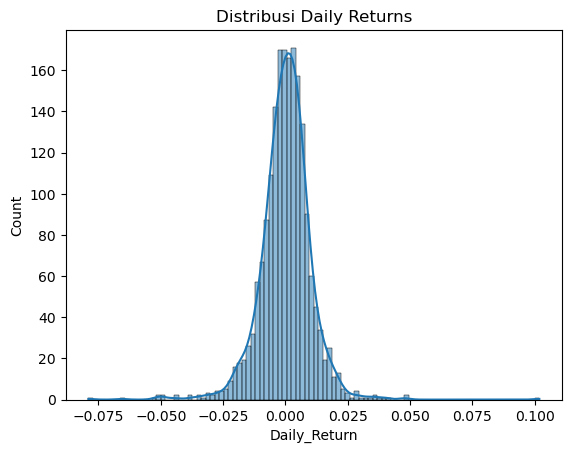

In [36]:
# Hitung daily return
data['Daily_Return'] = data['Close'].pct_change()

# Plot volatilitas (daily returns)
data['Daily_Return'].plot(figsize=(15, 7), title='Volatilitas Harian IHSG (Daily Returns)')
plt.ylabel('Persentase Perubahan')
plt.grid(True)
plt.show()

# Plot distribusi daily returns
import seaborn as sns
sns.histplot(data['Daily_Return'].dropna(), bins=100, kde=True)
plt.title('Distribusi Daily Returns')

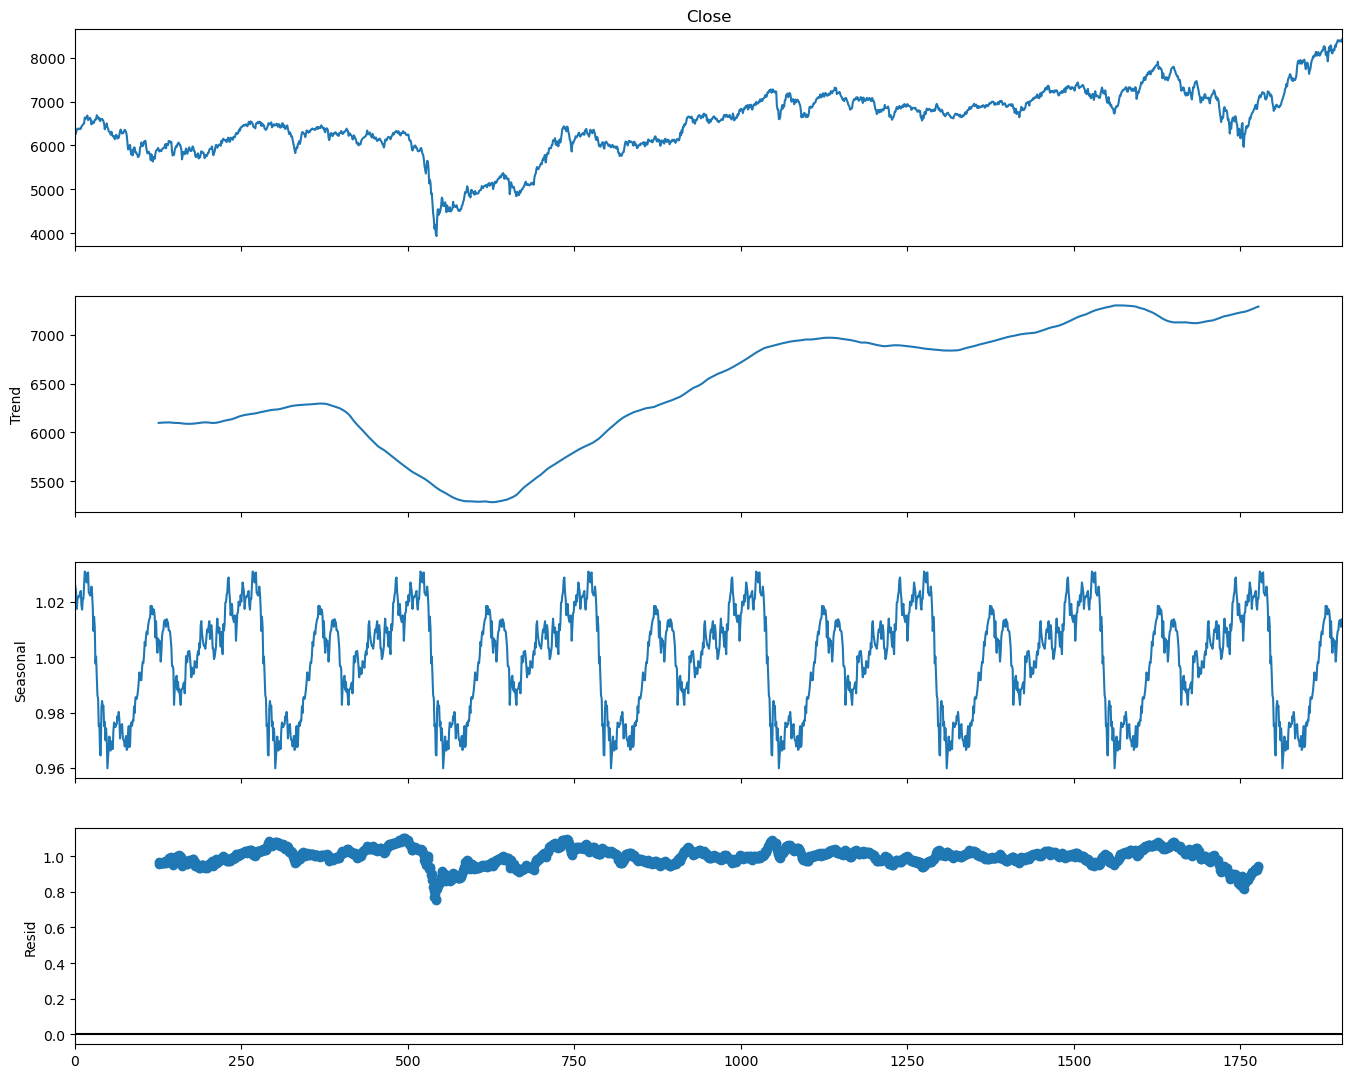

In [37]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Gunakan model 'multiplicative' karena varians cenderung tumbuh seiring harga
# Gunakan period=252 (kira-kira jumlah hari bursa dalam setahun) untuk melihat siklus tahunan
result = seasonal_decompose(data['Close'], model='multiplicative', period=252)

fig = result.plot()
fig.set_size_inches(15, 12)
plt.show()

## Feature Engineering

In [38]:
def preprocess_data(df):
    df = df.copy()
    # Indikator
    window = 14
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    short_ema = df['Close'].ewm(span=12, adjust=False).mean()
    long_ema = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = short_ema - long_ema
    df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

    sma_20 = df['Close'].rolling(window=20).mean()
    std_20 = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = sma_20 + (std_20 * 2)
    df['BB_Lower'] = sma_20 - (std_20 * 2)

    # Target
    df['Target_UpDown'] = (df['Close'].shift(-1) > df['Close']).astype(int)
    df['Target_DailyReturn'] = df['Close'].pct_change().shift(-1)
    df['Target_Volatility'] = df['Close'].pct_change().rolling(window=30).std().shift(-1)
    
    df.dropna(inplace=True)
    return df

## Preprocessing

## Model Implementation:

### XGBoost

In [39]:
def tune_and_train(X, y, mode):
    tscv = TimeSeriesSplit(n_splits=3)
    if mode == 'classifier':
        model = xgb.XGBClassifier(eval_metric='logloss', n_jobs=-1)
        scoring = 'accuracy'
    else:
        model = xgb.XGBRegressor(n_jobs=-1)
        scoring = 'neg_root_mean_squared_error'

    params = {'n_estimators': [100], 'learning_rate': [0.1], 'max_depth': [3, 5]}
    gs = GridSearchCV(model, params, cv=tscv, scoring=scoring, n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_

In [40]:
print("--- TRAIN XGBOOST ---")


df = preprocess_data(data)
features = ['RSI', 'MACD', 'MACD_Signal', 'Volume', 'High', 'Low', 'BB_Upper', 'BB_Lower']
X = df[features]

models = {}
targets = [('Target_UpDown', 'classifier'), 
            ('Target_DailyReturn', 'regressor'), 
            ('Target_Volatility', 'regressor')]

for target, mode in targets:
    print(f"Training {target}...")
    models[target] = tune_and_train(X, df[target], mode)

# Ensure output directory exists before saving
os.makedirs("../output/model", exist_ok=True)

with open("../output/model/XGBoost_IHSG.pkl", "wb") as f:
    pickle.dump(models, f)
print("Models Saved -> ../output/model/XGBoost_IHSG.pkl")

--- TRAIN XGBOOST ---
Training Target_UpDown...
Training Target_DailyReturn...
Training Target_Volatility...
Models Saved -> ../output/model/XGBoost_IHSG.pkl


### LSTM

In [41]:
def create_dataset(dataset, time_step=60):
    X, Y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)


In [42]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [50]:
data

,Date,Close,High,Low,Open,Volume
0,2018-01-02,6339.237793,6445.910156,6326.092773,6366.083008,52168200
1,2018-01-03,6251.479004,6342.190918,6220.694824,6341.270996,48866400
2,2018-01-04,6292.320801,6292.320801,6233.937012,6257.716797,57864900
3,2018-01-05,6353.737793,6353.737793,6278.724121,6279.457031,74223700
4,2018-01-08,6385.403809,6385.403809,6349.041992,6354.361816,66702400
...,...,...,...,...,...,...
1899,2025-11-12,8388.566406,8428.948242,8377.497070,8392.280273,491096300
1900,2025-11-13,8371.999023,8418.163086,8354.835938,8412.826172,534184900
1901,2025-11-14,8370.435547,8417.134766,8360.936523,8378.128906,422843300
1902,2025-11-17,8416.881836,8452.329102,8391.995117,8397.835938,382110500


In [62]:
print("--- TRAIN LSTM ---")

dataset = data.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X, y = create_dataset(scaled_data, TIME_STEP)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = build_model((X.shape[1], 1))
model.fit(X, y, batch_size=32, epochs=20, verbose=1)

model.save("../output/model/LSTM_IHSG.keras")
print("Model Saved -> ../output/model/LSTM_IHSG.keras")

--- TRAIN LSTM ---
Epoch 1/20


/home/bhazheng/.conda/envs/ml-zoomcamp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0293
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0049
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0041
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0040
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0039
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0034
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0035
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0034
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0034
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0031
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0032
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0026
Epoch 13/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0027
Epoch 14/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0027
Epoch 15/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0028
Epoch 16/20
58/

In [63]:
data

,Date,Close,High,Low,Open,Volume
0,2018-01-02,6339.237793,6445.910156,6326.092773,6366.083008,52168200
1,2018-01-03,6251.479004,6342.190918,6220.694824,6341.270996,48866400
2,2018-01-04,6292.320801,6292.320801,6233.937012,6257.716797,57864900
3,2018-01-05,6353.737793,6353.737793,6278.724121,6279.457031,74223700
4,2018-01-08,6385.403809,6385.403809,6349.041992,6354.361816,66702400
...,...,...,...,...,...,...
1899,2025-11-12,8388.566406,8428.948242,8377.497070,8392.280273,491096300
1900,2025-11-13,8371.999023,8418.163086,8354.835938,8412.826172,534184900
1901,2025-11-14,8370.435547,8417.134766,8360.936523,8378.128906,422843300
1902,2025-11-17,8416.881836,8452.329102,8391.995117,8397.835938,382110500


### Prophet

In [71]:
print("--- TRAIN PROPHET ---")

df_p = data.reset_index()[['Date', 'Close']]
df_p.columns = ['ds', 'y']
df_p['ds'] = df_p['ds'].dt.tz_localize(None)

model = Prophet(daily_seasonality=True)
model.fit(df_p)

with open("../output/model/Prophet_IHSG.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model Saved -> ../output/model/Prophet_IHSG.pkl")

--- TRAIN PROPHET ---


01:30:49 - cmdstanpy - INFO - Chain [1] start processing
01:30:50 - cmdstanpy - INFO - Chain [1] done processing


Model Saved -> ../output/model/Prophet_IHSG.pkl


## Evaluation & Interpretation

### XGBoost

In [65]:
print("--- PREDICT & EVALUATE XGBOOST ---")


with open("../output/model/XGBoost_IHSG.pkl", "rb") as f:
    models = pickle.load(f)

# 2. Preprocess & Split
df = preprocess_data(data)
features = ['RSI', 'MACD', 'MACD_Signal', 'Volume', 'High', 'Low', 'BB_Upper', 'BB_Lower']

# Ambil 20% data terakhir sebagai Test Set
split_idx = int(len(df) * 0.8)
X_test = df[features].iloc[split_idx:]

# 3. Evaluate Loop
targets = [('Target_UpDown', 'classifier'), 
            ('Target_DailyReturn', 'regressor'), 
            ('Target_Volatility', 'regressor')]

for target, mode in targets:
    y_test = df[target].iloc[split_idx:]
    model = models[target]
    preds = model.predict(X_test)

    print(f"\nEvaluasi {target}:")
    
    if mode == 'classifier':
        acc = accuracy_score(y_test, preds)
        print(f"Accuracy: {acc:.4f}")
        
        plt.figure(figsize=(5,4))
        sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
        plt.title(f'CM - {target} (Acc: {acc:.2f})')
        plt.savefig(f"../output/prediction/XGBoost_{target}_CM.png")
        plt.close()
        
    else:
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print(f"RMSE: {rmse:.4f}")
        
        plt.figure(figsize=(10,4))
        plt.plot(y_test.values, label='Actual', alpha=0.7)
        plt.plot(preds, label='Predicted', alpha=0.7)
        plt.title(f'Pred vs Act - {target} (RMSE: {rmse:.4f})')
        plt.legend()
        plt.savefig(f"../output/prediction/XGBoost_{target}_Plot.png")
        plt.close()

print("\nAll evaluations saved to ../output/prediction/")

--- PREDICT & EVALUATE XGBOOST ---

Evaluasi Target_UpDown:
Accuracy: 0.7787

Evaluasi Target_DailyReturn:
RMSE: 0.0095

Evaluasi Target_Volatility:
RMSE: 0.0007

All evaluations saved to ../output/prediction/


### LSTM

--- PREDICT & EVALUATE LSTM ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
RMSE: 143.32
Plot Saved -> ../output/prediction/LSTM_Evaluation.png


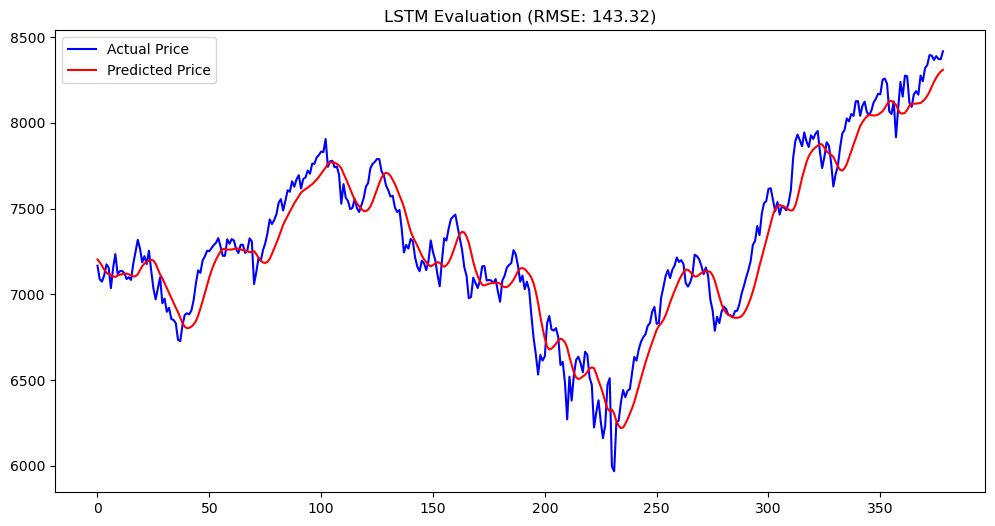

In [67]:
print("--- PREDICT & EVALUATE LSTM ---")

# 1. Load Data & Model
model = load_model("../output/model/LSTM_IHSG.keras")

# 2. Preprocess
dataset = data.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 3. Split Test Data (Last 20%)
test_len = int(len(dataset) * 0.2)
test_data = scaled_data[-(test_len + TIME_STEP):] # Ambil buffer time_step

X_test, y_test = create_dataset(test_data, TIME_STEP)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Predict
preds = model.predict(X_test)
preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. Evaluate
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
print(f"RMSE: {rmse:.2f}")

# 6. Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(preds_inv, label='Predicted Price', color='red')
plt.title(f'LSTM Evaluation (RMSE: {rmse:.2f})')
plt.legend()
plt.savefig("../output/prediction/LSTM_Evaluation.png")
print("Plot Saved -> ../output/prediction/LSTM_Evaluation.png")


### Prophet

--- PREDICT & EVALUATE PROPHET ---
RMSE: 248.82
Plot Saved -> ../output/prediction/Prophet_Evaluation.png


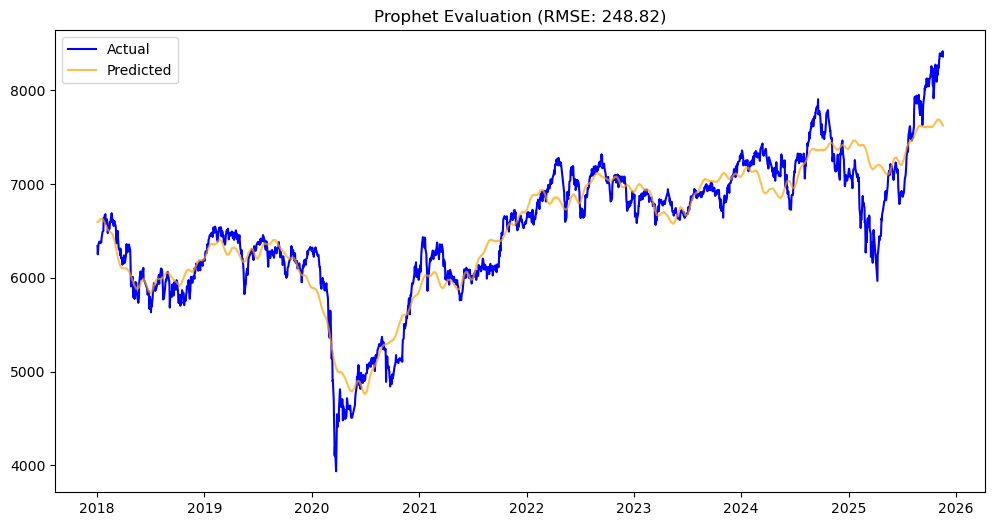

In [69]:
print("--- PREDICT & EVALUATE PROPHET ---")

# 1. Load Data & Model
with open("../output/model/Prophet_IHSG.pkl", "rb") as f:
    model = pickle.load(f)

# 2. Prepare Actuals
df_actual = data.reset_index()[['Date', 'Close']]
df_actual.columns = ['ds', 'y']
df_actual['ds'] = df_actual['ds'].dt.tz_localize(None)

# 3. Predict (on history to compare)
future = model.make_future_dataframe(periods=0) 
forecast = model.predict(future)

# 4. Evaluate
# Merge to ensure alignment
cmp = pd.merge(df_actual, forecast[['ds', 'yhat']], on='ds')
rmse = np.sqrt(mean_squared_error(cmp['y'], cmp['yhat']))
print(f"RMSE: {rmse:.2f}")

# 5. Plot
plt.figure(figsize=(12,6))
plt.plot(cmp['ds'], cmp['y'], label='Actual', color='blue')
plt.plot(cmp['ds'], cmp['yhat'], label='Predicted', color='orange', alpha=0.7)
plt.title(f'Prophet Evaluation (RMSE: {rmse:.2f})')
plt.legend()
plt.savefig("../output/prediction/Prophet_Evaluation.png")
print("Plot Saved -> ../output/prediction/Prophet_Evaluation.png")

## Finetuning

## LSTM

In [86]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

def build_model(input_shape):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),

        LSTM(64, return_sequences=False),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.0005), loss='mse')
    return model

print("--- TRAIN LSTM ---")

dataset = data.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

X, y = create_dataset(scaled_data, TIME_STEP)
X = X.reshape(X.shape[0], X.shape[1], 1)

model = build_model((X.shape[1], 1))

callbacks = [
    EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
]


model.fit(X, y, epochs=40, batch_size=32, callbacks=callbacks)
model.save("../output/model/LSTM_IHSG_tuned.keras")
print("Model Saved -> ../output/model/LSTM_IHSG_tuned.keras")

--- TRAIN LSTM ---
Epoch 1/40


/home/bhazheng/.conda/envs/ml-zoomcamp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 0.0559
Epoch 2/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0048
Epoch 3/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0039
Epoch 4/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0035
Epoch 5/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0035
Epoch 6/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0030
Epoch 7/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0028
Epoch 8/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0027
Epoch 9/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0027
Epoch 10/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0025
Epoch 11/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0027
Epoch 12/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024
Epoch 13/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0023
Epoch 14/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0023
Epoch 15/40
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0021
Epoch 16/40
58/

--- PREDICT & EVALUATE LSTM ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
RMSE: 237.69
Plot Saved -> ../output/prediction/LSTM_Evaluation_tuned.png


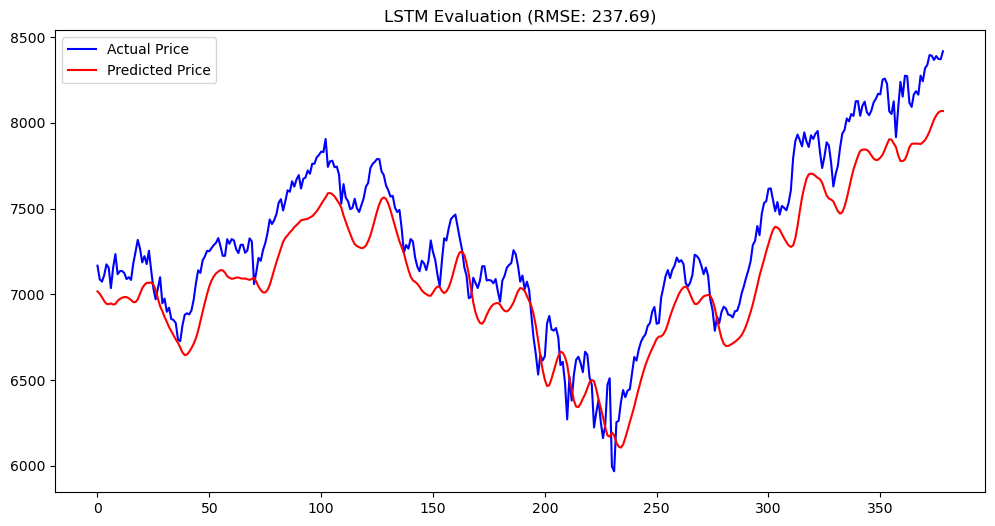

In [87]:
print("--- PREDICT & EVALUATE LSTM ---")

# 1. Load Data & Model
model = load_model("../output/model/LSTM_IHSG_tuned.keras")

# 2. Preprocess
dataset = data.filter(['Close']).values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# 3. Split Test Data (Last 20%)
test_len = int(len(dataset) * 0.2)
test_data = scaled_data[-(test_len + TIME_STEP):] # Ambil buffer time_step

X_test, y_test = create_dataset(test_data, TIME_STEP)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Predict
preds = model.predict(X_test)
preds_inv = scaler.inverse_transform(preds)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# 5. Evaluate
rmse = np.sqrt(mean_squared_error(y_test_inv, preds_inv))
print(f"RMSE: {rmse:.2f}")

# 6. Plot
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual Price', color='blue')
plt.plot(preds_inv, label='Predicted Price', color='red')
plt.title(f'LSTM Evaluation (RMSE: {rmse:.2f})')
plt.legend()
plt.savefig("../output/prediction/LSTM_Evaluation_tuned.png")
print("Plot Saved -> ../output/prediction/LSTM_Evaluation_tuned.png")


## Prophet

In [83]:

df_p = data.reset_index()[['Date', 'Close']]
df_p.columns = ['ds', 'y']
df_p['ds'] = df_p['ds'].dt.tz_localize(None)

# LOG TRANSFORM
# df_p['y'] = np.log(df_p['y'])

model = Prophet(
    changepoint_prior_scale=0.2,
    seasonality_prior_scale=5,
    yearly_seasonality=True,
    daily_seasonality=True
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=7)

model.fit(df_p)

with open("../output/model/Prophet_IHSG_tuned.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model Saved -> ../output/model/Prophet_IHSG_tuned.pkl")


01:47:42 - cmdstanpy - INFO - Chain [1] start processing
01:47:47 - cmdstanpy - INFO - Chain [1] done processing


Model Saved -> ../output/model/Prophet_IHSG_tuned.pkl


--- PREDICT & EVALUATE PROPHET ---
RMSE: 176.71
Plot Saved -> ../output/prediction/Prophet_Evaluation_tuned.png


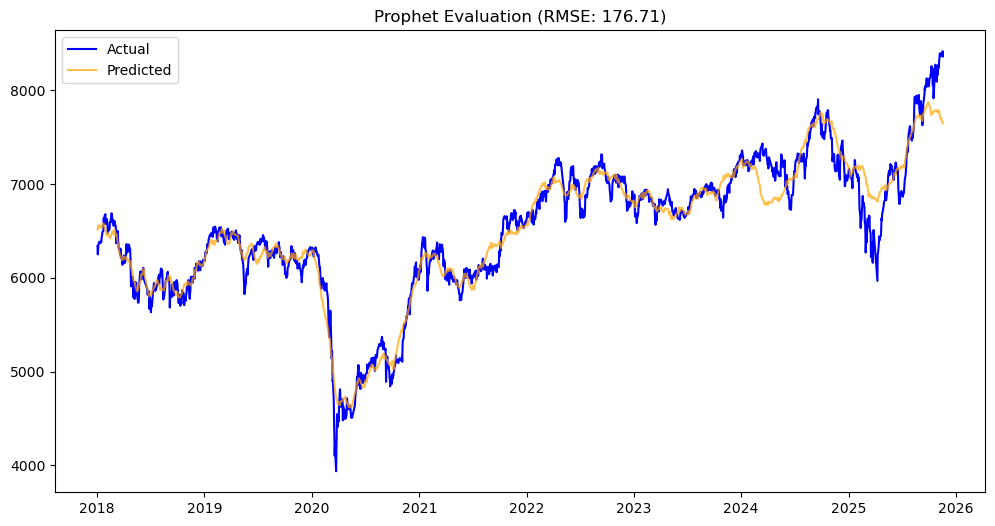

In [84]:
print("--- PREDICT & EVALUATE PROPHET ---")

# 1. Load Data & Model
with open("../output/model/Prophet_IHSG_tuned.pkl", "rb") as f:
    model = pickle.load(f)

# 2. Prepare Actuals
df_actual = data.reset_index()[['Date', 'Close']]
df_actual.columns = ['ds', 'y']
df_actual['ds'] = df_actual['ds'].dt.tz_localize(None)

# 3. Predict (on history to compare)
future = model.make_future_dataframe(periods=0) 
forecast = model.predict(future)

# 4. Evaluate
# Merge to ensure alignment
cmp = pd.merge(df_actual, forecast[['ds', 'yhat']], on='ds')
rmse = np.sqrt(mean_squared_error(cmp['y'], cmp['yhat']))
print(f"RMSE: {rmse:.2f}")

# 5. Plot
plt.figure(figsize=(12,6))
plt.plot(cmp['ds'], cmp['y'], label='Actual', color='blue')
plt.plot(cmp['ds'], cmp['yhat'], label='Predicted', color='orange', alpha=0.7)
plt.title(f'Prophet Evaluation (RMSE: {rmse:.2f})')
plt.legend()
plt.savefig("../output/prediction/Prophet_Evaluation_tuned.png")
print("Plot Saved -> ../output/prediction/Prophet_Evaluation_tuned.png")